In [ ]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model 
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model 
from keras import backend as K 

import numpy as np
import matplotlib.pyplot as plt 
import os

In [ ]:
def sampling(args):
    z_mean, z_log_var = args 
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    epsilon = K.random_normal(shape = [batch, dim])
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
from skimage import io 
from skimage import transform as tr
def load_data(data_dir, batch_size = 1000):
    files = os.listdir(data_dir)
    imgs = []
    ids = np.random.choice(len(files), batch_size)
    for i in ids:
        imgs.append(tr.resize(io.imread(data_dir + '/' + files[i]), [92, 92, 3]))
    return np.array(imgs)

In [ ]:
x_tr1 = load_data('data', 5)

In [ ]:
plt.imshow(x_tr1[4])

In [ ]:
image_size = x_tr1.shape[1]

In [ ]:
#Normalize if not already normalized 
if np.max(x_tr1[1]) >= 1:
    x_tr1 = x_tr1 / np.max(x_tr1)

In [ ]:
x_tr1.shape

In [ ]:
x_tr1 = np.reshape(x_tr1, [-1, image_size, image_size, 3])

In [ ]:
#network params 
input_shape = [image_size, image_size, 3]
batch_size = 128
kernel_size = 3 
latent_dim = 64
epoch = 30 

int_d1 = 32
int_d2 = 64

In [ ]:
#encoder model 
inputs = Input(shape = input_shape, name = 'en_in')

x = Conv2D(filters = int_d1, kernel_size = kernel_size, activation = 'relu', strides = 2, padding = 'same')(inputs)
x = Conv2D(filters = int_d2, kernel_size = kernel_size, activation = 'relu', strides = 2, padding = 'same')(x)

shape = K.int_shape(x) #shape info for the decoder network 

# Q(z|X) [Latent vector]
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)

z_mean = Dense(latent_dim, name = 'zm')(x)
z_log_var = Dense(latent_dim, name = 'zlv')(x)

#Reparam 
z = Lambda(sampling, output_shape = [latent_dim,], name = 'z')([z_mean, z_log_var])

In [ ]:
#instantiate encoder 
encoder = Model(inputs, [z_mean, z_log_var, z], name = 'encoder')
encoder.summary()

In [ ]:
#decocder model 
latent_inputs = Input(shape = [latent_dim], name = 'z_samp')
#Dense layer from latent space 
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
#reshape into image 
x = Reshape([shape[1], shape[2], shape[3]])(x)

#Upsampling
x = Conv2DTranspose(filters = int_d2, kernel_size = kernel_size, activation = 'relu', strides = 2, padding = 'same')(x)
x = Conv2DTranspose(filters = int_d1, kernel_size = kernel_size, activation = 'relu', strides = 2, padding = 'same')(x)

#Super-Resolution 
x = Conv2D(filters = 64, kernel_size = 9, activation = 'relu', padding = 'same')(x)
x = Conv2D(filters = 32, kernel_size = 5, activation = 'relu', padding = 'same')(x)
outputs = Conv2D(filters = 3, kernel_size = 3, activation = 'linear', padding = 'same', name = 'deout')(x)
#
#outputs = Conv2DTranspose(filters = 3, kernel_size = kernel_size, activation = 'linear', padding = 'same', name = 'deout')(x)

In [ ]:
#instantiate decoder model 
decoder = Model(latent_inputs, outputs, name = 'dec')
decoder.summary()

In [ ]:
#instantiate VAE model 
out_vae = decoder(encoder(inputs)[2])
vae = Model(inputs, out_vae, name = 'vae')

In [ ]:
#Train model 
#VAE loss = kl_loss + reconstruction loss 

kl_coef = 0.01

recon_loss = mse(K.flatten(inputs), K.flatten(out_vae))
recon_loss *= image_size * image_size 

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis = -1)
kl_loss *= -0.5 * kl_coef 

vae_loss = K.mean(recon_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer = 'adam')
vae.summary()

In [ ]:
# train the autoencoder

for i in range(100):
    x_tr1 = load_data('data', 1024)
    
    print(i)
    vae.fit(x_tr1, epochs=epoch, batch_size = batch_size)
    vae.save_weights('vae_cnn_mnist.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


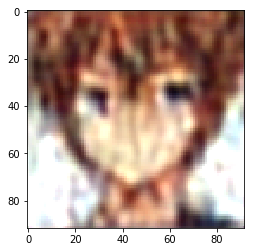

In [91]:
plt.imshow(vae.predict(x_tr1[1].reshape([1, 92, 92, 3]))[0])

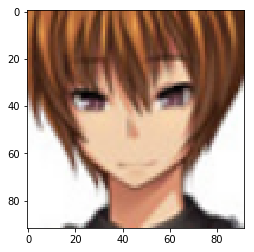

In [95]:
plt.imshow(x_tr1[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


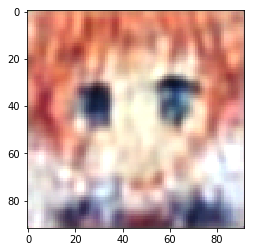

In [97]:
plt.imshow(vae.predict(x_tr1[3].reshape([1, 92, 92, 3]))[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


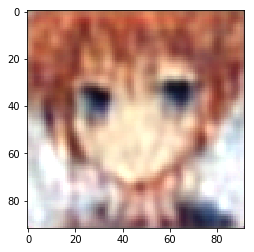

In [99]:
x = encoder.predict(x_tr1[3].reshape([1, 92, 92, 3]))[2]
y = encoder.predict(x_tr1[1].reshape([1, 92, 92, 3]))[2]
al = 0.5
k = x * al + y * (1- al) 

plt.imshow(decoder.predict(k)[0])

In [ ]:
for j in range(5):
    x = encoder.predict(x_tr1[j].reshape([1, 92, 92, 3]))[2]
    y = encoder.predict(x_tr1[j+1].reshape([1, 92, 92, 3]))[2]
    for i in range(20):
        al = i/19
        k = y * al + x * (1- al) 
        plt.imsave( 'lat_int_' + str(j) + '_' + str(i) + '.png', decoder.predict(k)[0])
        plt.imsave( 'g_tru' + str(j) + '_' + str(i) + '.png', x_tr1[j])
    

In [ ]:
for j in range(20):
    x = encoder.predict(x_tr1[j].reshape([1, 92, 92, 3]))[2]
    plt.imsave( 'rcon' + str(j) + '.png', decoder.predict(x)[0])
    plt.imsave( 'g_tru' + str(j) + '.png', x_tr1[j])
    

## SRCNN

now we try to map from 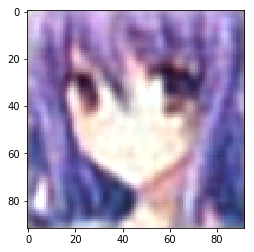
to 
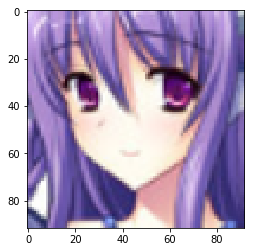


In [ ]:
sr_input = Input(shape = input_shape, name = 'srin')
x = Conv2D(filters = 64, kernel_size = 9, activation = 'relu', padding = 'same')(sr_input)
x = Conv2D(filters = 32, kernel_size = 5, activation = 'relu', padding = 'same')(x)
sr_outputs = Conv2D(filters = 3, kernel_size = 5, activation = 'linear', padding = 'same', name = 'deout')(x)

srcnn = Model(sr_input, sr_outputs, name = 'srcnn')
srcnn.compile(optimizer = 'adam', loss='mean_squared_error')
srcnn.summary()

In [ ]:
for i in range(100):
    x_tr1 = load_data('data', 512)
    pred_x = vae.predict(x_tr1)
    
    print(i)
    
    srcnn.fit(x_tr1, pred_x,epochs=epoch, batch_size = batch_size)
    srcnn.save_weights('srcnn_vae.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


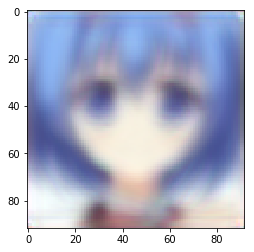

In [100]:
plt.imshow(srcnn.predict(x_tr1[:50])[8])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


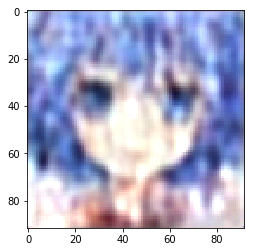

In [101]:
plt.imshow(vae.predict(x_tr1[:50])[8])

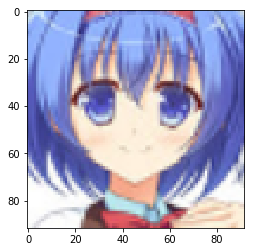

In [102]:
plt.imshow(x_tr1[:50][8])

In [ ]:
for j in range(5):
    x = encoder.predict(x_tr1[j + 10].reshape([1, 92, 92, 3]))[2]
    y = encoder.predict(x_tr1[j+1 + 10].reshape([1, 92, 92, 3]))[2]
    for i in range(20):
        al = i/19
        k = y * al + x * (1- al) 
        plt.imsave( 'lat_int_sr_' + str(j) + '_' + str(i) + '.png', srcnn.predict(decoder.predict(k))[0])        
        plt.imsave( 'lat_int_' + str(j) + '_' + str(i) + '.png', decoder.predict(k)[0])
        #plt.imsave( 'g_tru' + str(j) + '_' + str(i) + '.png', x_tr1[j])
    